# Project - House Price

## 1. Setup

### 1.1 Libraries

In [2]:
import pkg_resources
if pkg_resources.get_distribution("scikit-learn").version != '0.22.1':
    !conda install --yes scikit-learn

Solving environment: ...working... done

# All requested packages already installed.



In [11]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

### 1.2 Data

In [4]:
sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

### 2.1 Check dataset

In [5]:
sales.shape

(1584, 16)

There is 16 features in this dataset.

In [6]:
sales.head()

,sale_price,year_sold,year_built,lot_area,basement_area,living_area,full_bath,half_bath,bedroom,garage_cars,garage_area,ac,zoning,neighborhood,quality,condition
0,244000,2010,1968,11160,2110,2110,2,1,3,2,522,Y,Residential_Low_Density,nb_07,good,average
1,189900,2010,1997,13830,928,1629,2,1,3,2,482,Y,Residential_Low_Density,nb_22,average,average
2,191500,2010,1992,5005,1280,1280,2,0,2,2,506,Y,Residential_Low_Density,nb_10,good,average
3,236500,2010,1995,5389,1595,1616,2,0,2,2,608,Y,Residential_Low_Density,nb_10,good,average
4,189000,2010,1999,7500,994,1804,2,1,3,2,442,Y,Residential_Low_Density,nb_22,good,average


In [7]:
# check the dataset
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 16 columns):
sale_price       1584 non-null int64
year_sold        1584 non-null int64
year_built       1584 non-null int64
lot_area         1584 non-null int64
basement_area    1584 non-null int64
living_area      1584 non-null int64
full_bath        1584 non-null int64
half_bath        1584 non-null int64
bedroom          1584 non-null int64
garage_cars      1584 non-null int64
garage_area      1584 non-null int64
ac               1584 non-null object
zoning           1584 non-null object
neighborhood     1584 non-null object
quality          1584 non-null object
condition        1584 non-null object
dtypes: int64(11), object(5)
memory usage: 198.1+ KB


At the first, we can use the funtion `.info` to get concise summary of `sales` dataframe. As we can see there are no null values present in the dataset

In [8]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = sales.select_dtypes(include='object').columns
numerical_features = sales.select_dtypes(exclude='object').columns
numerical_features = numerical_features.drop('sale_price')

print("The numerical features is :\n", numerical_features)
print("The total of numerical features is : " + str(len(numerical_features)))
print("")
print("The categorical features is :\n", categorical_features)
print("The total of categorical features : " + str(len(categorical_features)))

The numerical features is :
 Index(['year_sold', 'year_built', 'lot_area', 'basement_area', 'living_area',
       'full_bath', 'half_bath', 'bedroom', 'garage_cars', 'garage_area'],
      dtype='object')
The total of numerical features is : 10

The categorical features is :
 Index(['ac', 'zoning', 'neighborhood', 'quality', 'condition'], dtype='object')
The total of categorical features : 5


In this dataset have 10 continuous features and 5 categorical features.

### 2.2 Analyzing the target variable (sale_price)

`sale_price` is the target variable, lets see how it looks like.

In [9]:
# lets check the target variable "sale_price"
sales['sale_price'].describe()

count      1584.000000
mean     174600.288510
std       72033.178387
min       35000.000000
25%      129000.000000
50%      156225.000000
75%      203033.750000
max      755000.000000
Name: sale_price, dtype: float64

There are no negative values in the dataset for sale price which is good.

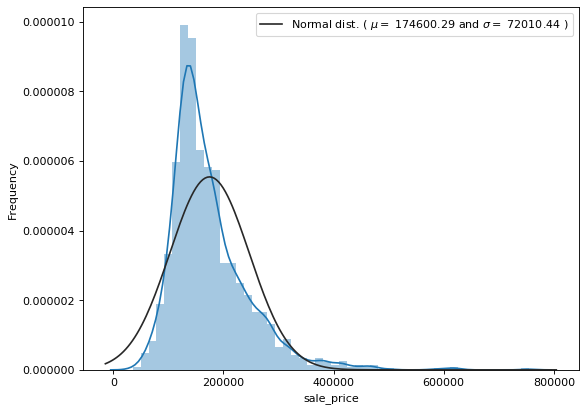

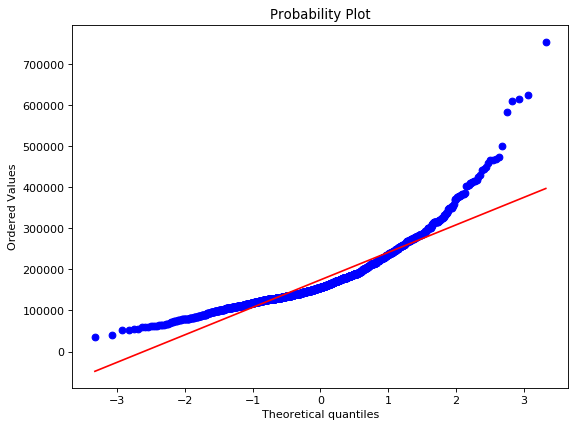

In [12]:
from scipy import stats
from scipy.stats import norm, skew

# lets check the distribution of saleprice
sns.distplot(sales.sale_price, fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(sales['sale_price'])

# plot with the distribution
plt.legend(['Normal dist. ( $\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

#Probablity plot
fig = plt.figure()
stats.probplot(sales['sale_price'], plot=plt)
plt.show()

In [13]:
#skewness and kurtosis
print("Skewness: %f" % sales['sale_price'].skew())
print("Kurtosis: %f" % sales['sale_price'].kurt())

Skewness: 1.954549
Kurtosis: 7.186927


`sale_price` seems to be right skewed, so we need to tranform this variable it or  this will adversly impact our model.

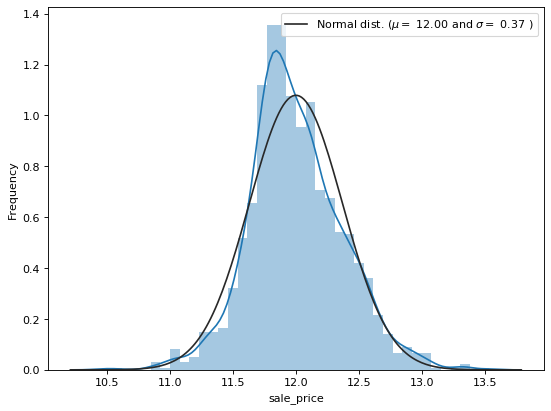

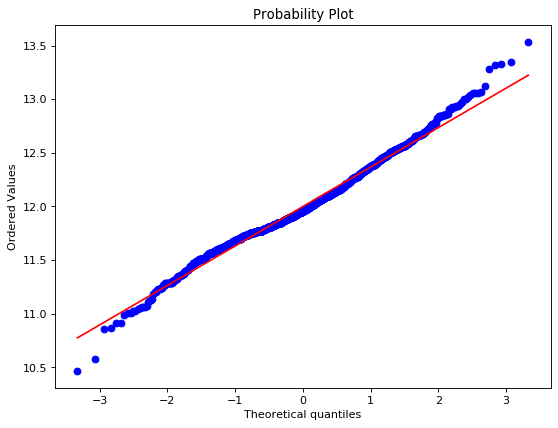

In [14]:
# Using log to transform sale_price then check the distribution again
# lets check the distribution of saleprice
sns.distplot(np.log(sales.sale_price), fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(np.log(sales['sale_price']))

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

#Probablity plot
fig = plt.figure()
stats.probplot(np.log(sales['sale_price']), plot=plt)
plt.show()

If we try to transform the variable of sale_price, we can see the data simialr to normal.

### 2.3 Relationship with continuous features

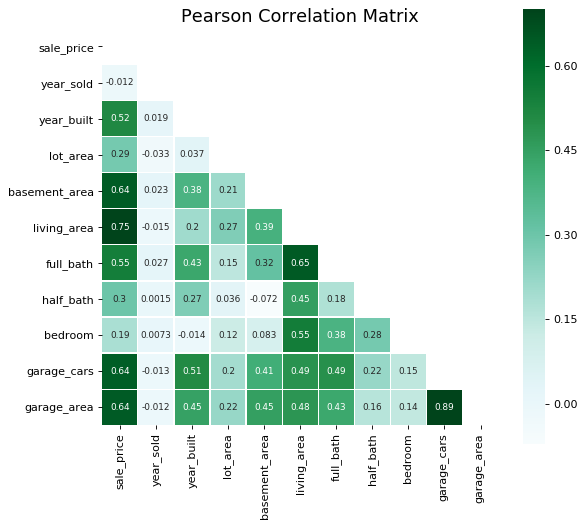

In [15]:
# correlation map
mask = np.zeros_like(sales.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)]= True 

f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation Matrix',fontsize=16)

sns.heatmap(sales.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [16]:
print("Find most important features relative to target")
corr = sales.corr()
corr.sort_values(['sale_price'], ascending = False, inplace = True)
print(corr.sale_price)

Find most important features relative to target
sale_price       1.000000
living_area      0.745171
garage_area      0.643181
basement_area    0.641892
garage_cars      0.639224
full_bath        0.546798
year_built       0.515272
half_bath        0.300237
lot_area         0.285493
bedroom          0.186719
year_sold       -0.011660
Name: sale_price, dtype: float64


According to the above, we can notice that 
* The correaltion of `sale_price` is lower with `year_sold`, `lot_area`, `half_bath` and `bedroom` since there correlation under 0.5.
* `living_area` has high correaltion with `full_bath` and `bedroom`.
* `garage_cars` has high correlation with `garage_area` and `year_build`.

In [17]:
from scipy.stats import skew 
sales_num = sales[numerical_features]
skewness = sales_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

lot_area         11.782904
living_area       1.008922
half_bath         0.727706
basement_area     0.529231
full_bath         0.348596
garage_area       0.221875
bedroom           0.211698
year_sold         0.073479
garage_cars      -0.050316
year_built       -0.556842
dtype: float64

In [18]:
skewness = skewness[abs(skewness)>0.5]
skewness.index

Index(['year_built', 'lot_area', 'basement_area', 'living_area', 'half_bath'], dtype='object')

We can see that the variable of `year_built`, `lot_area`, `basement_area`, `living_area`, `half_bath` they are skewed so we need to handle it.

Text(0, 0.5, 'sale_price')

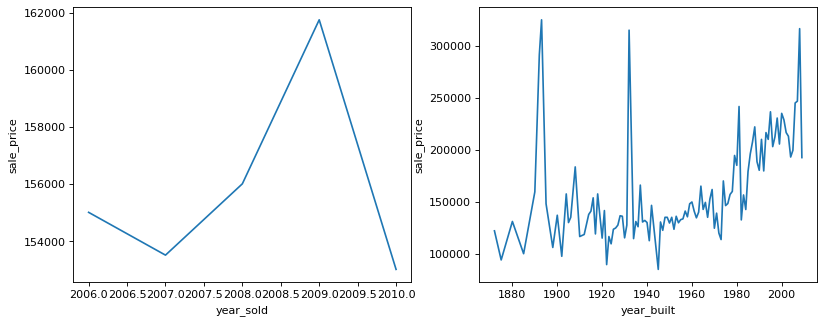

In [19]:
plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(sales.groupby('year_sold')['sale_price'].median())
plt.xlabel('year_sold')
plt.ylabel('sale_price')
plt.subplot(2,2,2)
plt.plot(sales.groupby('year_built')['sale_price'].median())
plt.xlabel('year_built')
plt.ylabel('sale_price')

We can see the trend of `sale_price` with `year_built` it shows a increasing trend which seems real in real state scenario.

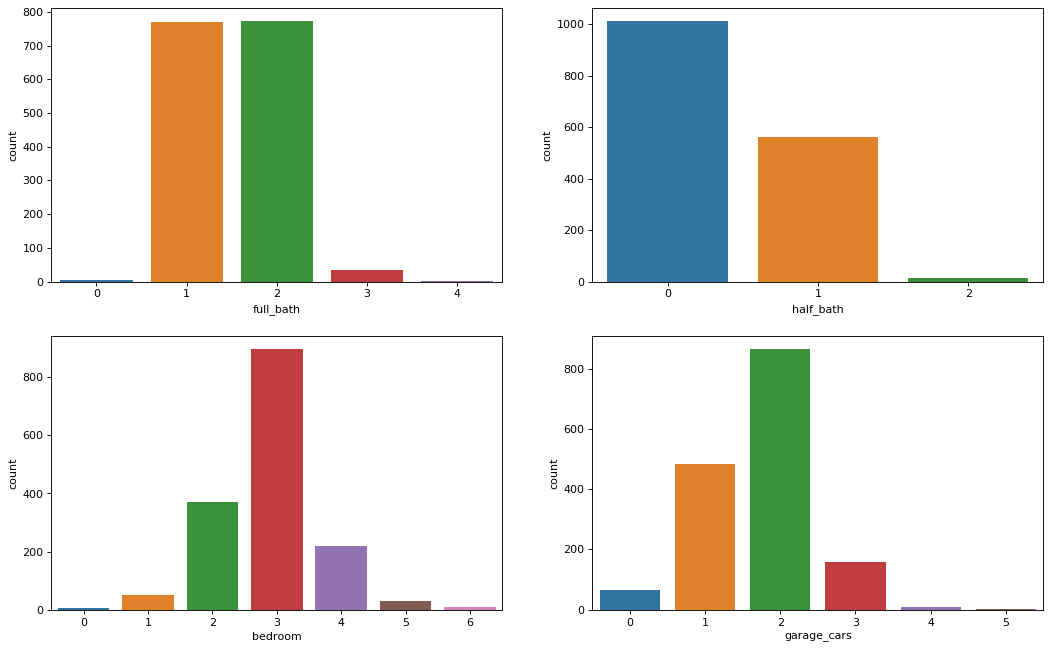

In [20]:
part_feature = sales[['full_bath', 'half_bath', 'bedroom', 'garage_cars']]
plt.figure(figsize = (16,48))
for idx,col in enumerate(part_feature):
    plt.subplot(9,2,idx+1)
    sns.countplot(sales[col])

It seems the variance for those variables are not low.

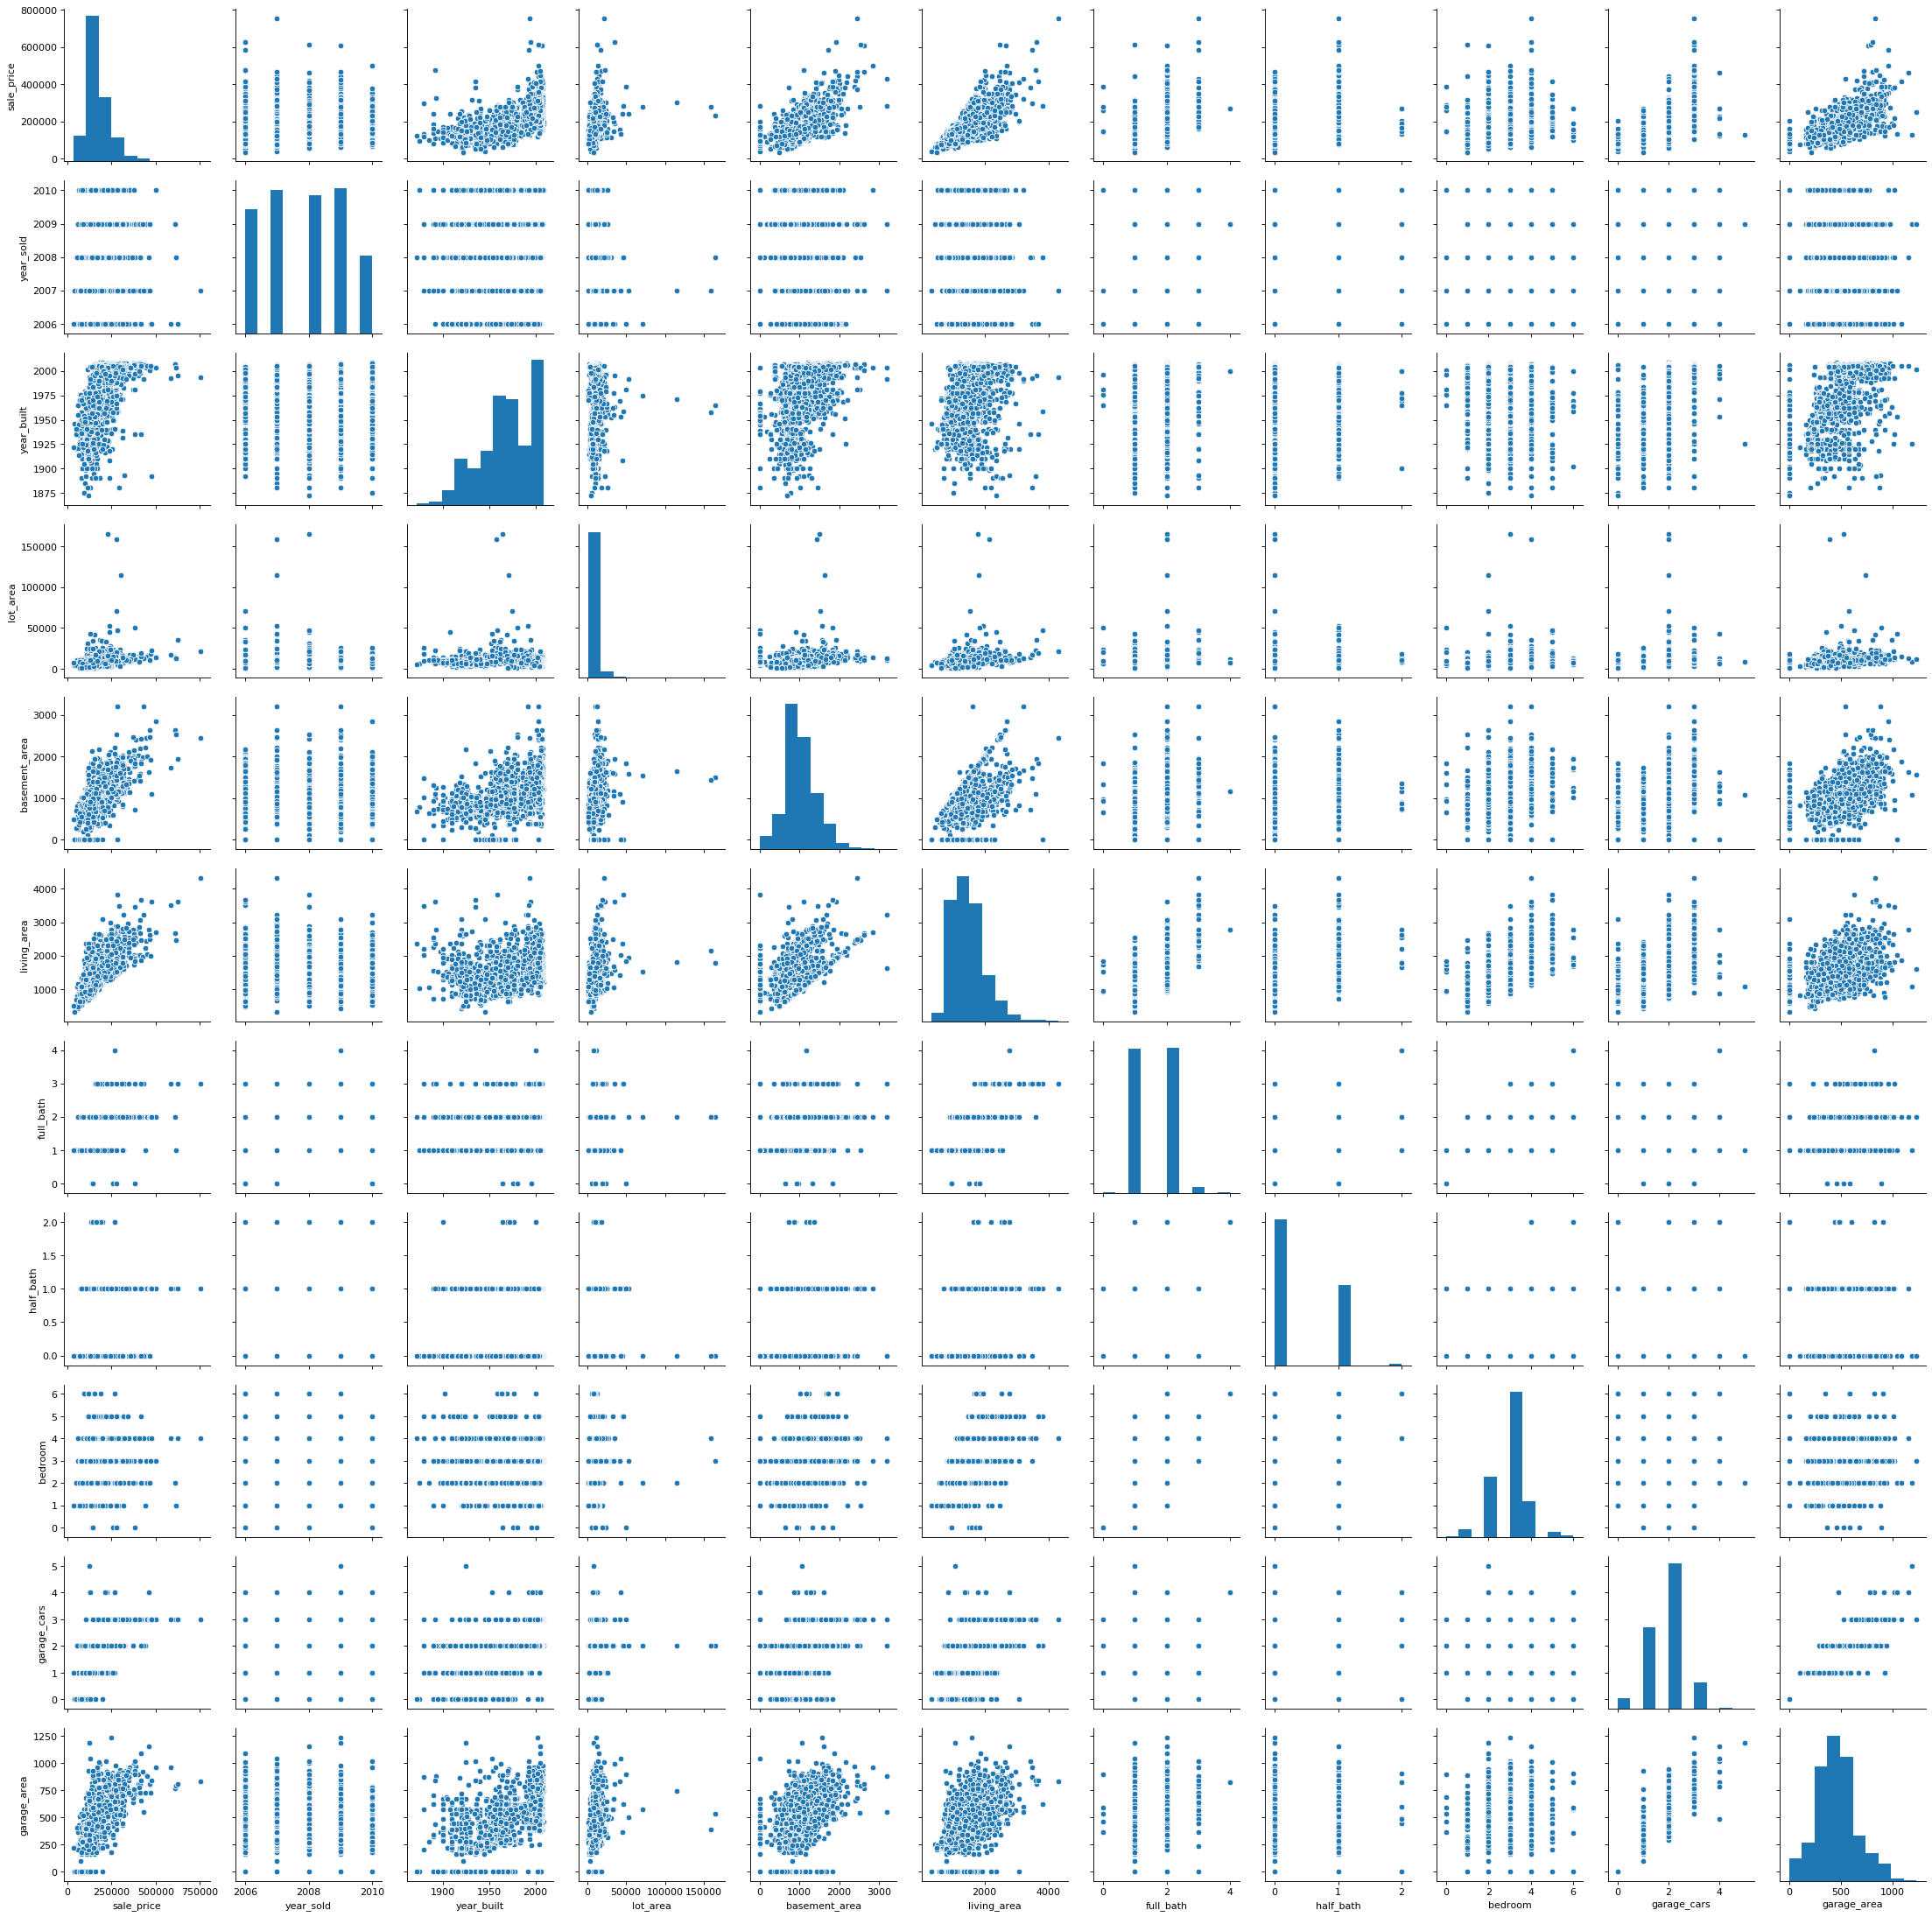

In [21]:
# Constructing a pairs plot of data and examining the relationships between our variables.
sns.pairplot(data = sales)

Although we already know some of the main figures, this scatter plot gives us a reasonable idea about variables relationships:
* The variable of `sale_price` seems to have the clearest relationship with `basement_area`, `living_area` and `garage_area`.

### 2.4 Relationship with categorical features

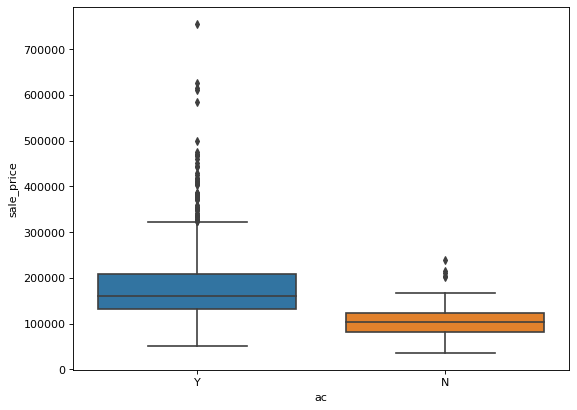

In [22]:
# visualizing the relationship between variable of 'sale_price' and 'ac'
# box plot ac/sale_price
var = 'ac'
data = pd.concat([sales['sale_price'], sales[var]], axis=1)
sns.boxplot(x=var, y="sale_price", data=data)

We can notice the `ac` will influence `sale_price` since the mean and distribution is different.

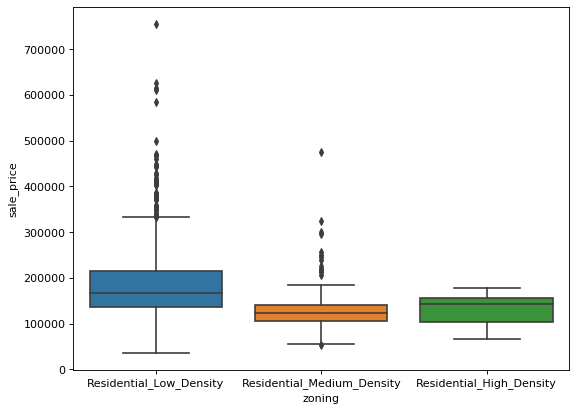

In [23]:
# visualizing the relationship between variable of 'sale_price' and 'zoning'
# box plot zoning/sale_price
var = 'zoning'
data = pd.concat([sales['sale_price'], sales[var]], axis=1)
sns.boxplot(x=var, y="sale_price", data=data)

We can notice the `zoning` will also influence `sale_price`.

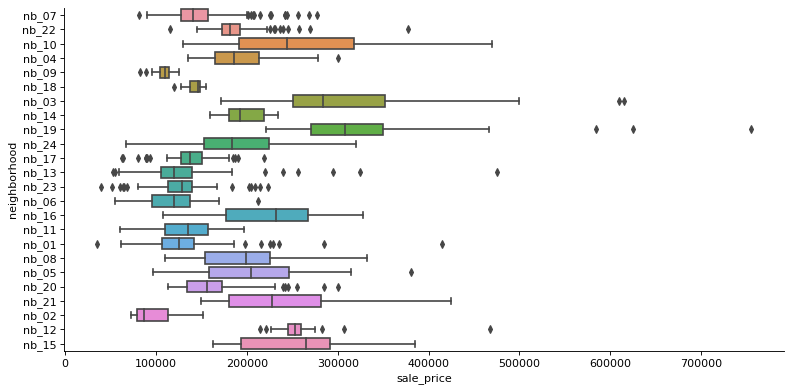

In [24]:
# visualizing the relationship between variable of 'sale_price' and 'neighborhood'
sns.catplot(
    x = "sale_price",
    y = "neighborhood",
    kind = "box",
    data = sales,
    aspect = 2
)

We can notice the `neighborhood` is relate with `sale_price`.

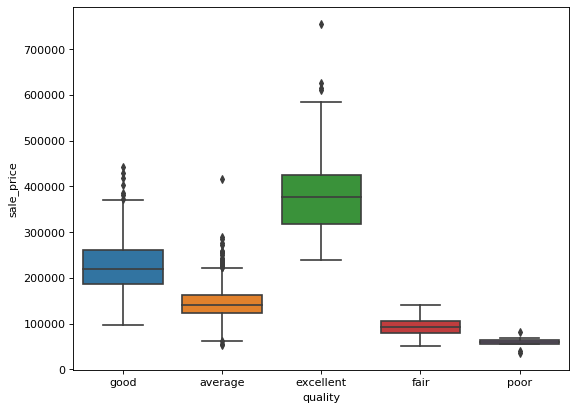

In [25]:
# visualizing the relationship between variable of 'sale_price' and 'quality'
# box plot quality/sale_price
var = 'quality'
data = pd.concat([sales['sale_price'], sales[var]], axis=1)
sns.boxplot(x=var, y="sale_price", data=data)

The variable `quality` also will affect `sale_price`. The mean of `sale_price` for excellent quality is higher than poor one.

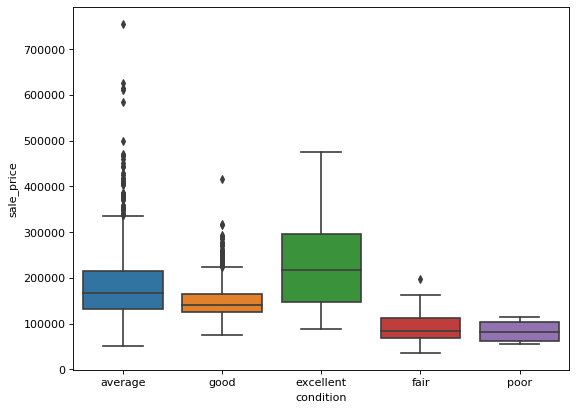

In [26]:
# visualizing the relationship between variable of 'sale_price' and 'condition'
# box plot condition/sale_price
var = 'condition'
data = pd.concat([sales['sale_price'], sales[var]], axis=1)
sns.boxplot(x=var, y="sale_price", data=data)

The variable `condition` shows it relates with `sale_price`.

***Summary of exploratory data analysis:***
1. In the dataframe, there are continuous and categorical variables and no NA in the dataset.
2. `sale_price`, `year_built`, `lot_area`, `basement_area`, `living_area`, `half_bath` are skewed.
3. `sale_price` has high correlation with most of continuous variables aside from `year_sold`, `lot_area`, `half_bath` and `bedroom`.
4. There some variables have high correaltion:
    * `living_area` has high correaltion with `full_bath` and `bedroom`.
    * `garage_cars` has high correlation with `garage_area` and `year_build`.
5. It seems `sale_price` will be influenced by all of categorical variables.

### 2.6 Preprocessing

* Using log to transform `sale_price`, `year_built`, `lot_area` and `living_area`
* Getting dummy variable for categorical variables

In [27]:
# Define data X and y
# At fisrt use whole variables to build the model
X = sales.drop(['sale_price'], axis=1)

# Lets handle skewness in features of X, lets take log to get normal distribution
X.year_built = np.log(sales.year_built)
X.lot_area = np.log(sales.lot_area)
X.living_area = np.log(sales.living_area)

# Transform the categorical variable into dummy variables
X_dum = pd.get_dummies(X)

# Lets handle skewness in sale_price, lets take log to get normal distribution
y = np.log(sales.sale_price)

In [28]:
X_dum.head()

,year_sold,year_built,lot_area,basement_area,living_area,full_bath,half_bath,bedroom,garage_cars,garage_area,...,quality_average,quality_excellent,quality_fair,quality_good,quality_poor,condition_average,condition_excellent,condition_fair,condition_good,condition_poor
0,2010,7.584773,9.320091,2110,7.654443,2,1,3,2,522,...,0,0,0,1,0,1,0,0,0,0
1,2010,7.599401,9.534595,928,7.395722,2,1,3,2,482,...,1,0,0,0,0,1,0,0,0,0
2,2010,7.596894,8.518193,1280,7.154615,2,0,2,2,506,...,0,0,0,1,0,1,0,0,0,0
3,2010,7.598399,8.592115,1595,7.387709,2,0,2,2,608,...,0,0,0,1,0,1,0,0,0,0
4,2010,7.600402,8.922658,994,7.497762,2,1,3,2,442,...,0,0,0,1,0,1,0,0,0,0


## 3. Model Fitting and Tuning

***Purpose:*** Our purpose is to build a simple model to explain to third party. So our model cannot be complex. We need to drop some variables and we still hope this model have a good predictive ability. In the following step, we will step by step to refine our model.

In [29]:
# Helpful function:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(y_hat)))
    
    res = pd.DataFrame(
        data = {'y': np.exp(y), 'y_hat': np.exp(y_hat), 'resid': np.exp(y) - np.exp(y_hat)}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='x', y='y', color="grey", data =  pd.DataFrame(data={'x': [min(np.exp(y)),max(np.exp(y))],
                                                                            'y': [min(np.exp(y)),max(np.exp(y))]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

At first we use whole variables to fit the dataset.

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data into training data and test data which is 80% and 20% respectively
Xt, Xv, yt, yv = train_test_split(X_dum, y, test_size=0.2, random_state=0)

# At the first we scaling X to make all of the features to be unitless 
S = StandardScaler().fit(X_dum)
Xt_scaled = S.transform(Xt)
Xv_scaled = S.transform(Xv)

### Lasso Regression

In [31]:
from sklearn.linear_model import Lasso
# Using GridSearchCV to select alpha
alphas = np.linspace(0.001, 0.1, num=100)
lasso_gs = GridSearchCV(
    Lasso(),
    param_grid={'alpha': alphas},
    cv=KFold(5, True, random_state=1234),
    scoring='neg_mean_squared_error'
).fit(Xt_scaled, yt)

In [32]:
print( "best alpha:", lasso_gs.best_params_['alpha'])
print( "best rmse :", lasso_gs.best_score_ * -1)
print( "validation rmse:", model_fit(lasso_gs.best_estimator_, Xv_scaled, yv) )

best alpha: 0.001
best rmse : 0.012420262428117711
validation rmse: 20428.187423248906


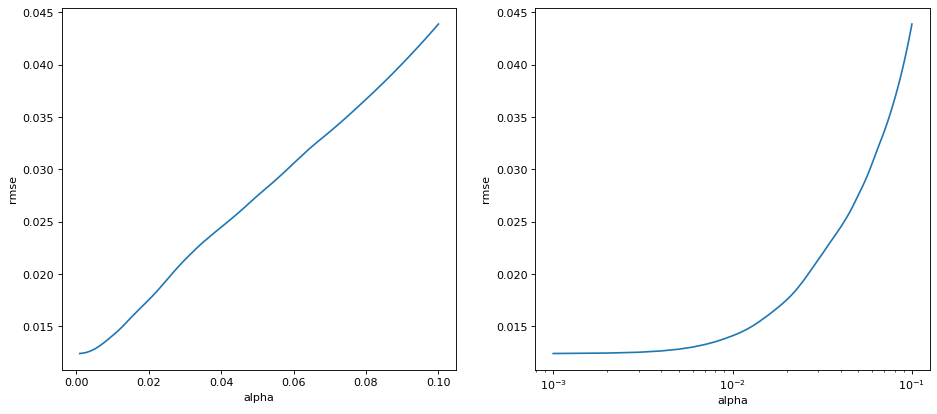

In [33]:
lasso_cv_res = pd.DataFrame().assign(
    alpha = alphas,
    rmse = -1 * lasso_gs.cv_results_['mean_test_score'],
    rmse_se = lasso_gs.cv_results_['std_test_score'] / np.sqrt(lasso_gs.n_splits_),
)

plt.figure(figsize=(14, 6))

plt.subplot(121)
sns.lineplot(x='alpha', y='rmse', data=lasso_cv_res)
plt.subplot(122)
sns.lineplot(x='alpha', y='rmse', data=lasso_cv_res).set_xscale('log')

In [34]:
from sklearn.linear_model import LinearRegression
GridSearchCV(
 LinearRegression(),
 param_grid = {},
 cv=KFold(5, True, random_state=1234),
 scoring="neg_root_mean_squared_error"
).fit(
 Xt_scaled, yt
).best_score_ * -1

0.11153190698112296

In this case it appears that the model's rmses nearly monotonically increase as $\alpha$ increases. This indicates that
the CV proceedure is exhibiting a preference for the linear regression mode. However, one of the suggestions employed by Hastie, et al. in their glmnet R package is instead of using the with the smallest mean rmse to instead use the largest value of that has an error metric (rmse) that is within 1 standard error of the minimum value of the error metric (rmse). We can find this value using the lasso_cv_res data frame we previously constructed.

In [35]:
i = lasso_cv_res.rmse.idxmin()
min_rmse = lasso_cv_res.rmse[i]
min_rmse_se = lasso_cv_res.rmse_se[i]
sub = lasso_cv_res.rmse <= min_rmse + min_rmse_se
alpha_1se = lasso_cv_res.alpha[ sub ].max()

lasso = Lasso(alpha=alpha_1se).fit(Xt_scaled, yt)
get_coefs(lasso)

array([ 1.19993685e+01, -0.00000000e+00,  8.94300926e-02,  4.06897595e-02,
        6.28178984e-02,  1.53425551e-01,  0.00000000e+00,  5.88209138e-03,
       -2.29360112e-02,  1.69347634e-02,  2.67989756e-02, -1.89311636e-02,
        5.55338717e-16, -2.16862422e-03,  1.19034399e-02, -0.00000000e+00,
       -6.54665734e-03, -9.78308394e-03,  8.40694535e-03, -2.43938287e-04,
        2.42645209e-02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -3.91829658e-04,  6.62092336e-03,  0.00000000e+00,  5.02660992e-03,
       -1.40379464e-03,  0.00000000e+00,  4.66080552e-03,  5.66546995e-03,
       -3.26956241e-03,  0.00000000e+00,  1.60701821e-02,  0.00000000e+00,
        2.24410742e-03,  0.00000000e+00,  5.90938394e-03, -1.38179014e-03,
       -0.00000000e+00,  5.32201551e-02, -6.18958947e-03,  4.66966227e-02,
       -3.86641001e-03, -0.00000000e+00,  2.11798058e-02, -2.40345447e-02,
        4.24823107e-02, -1.13116054e-02])

While this approach seems plausible / practical, it should be treated as at best a heuristic as I have not been able to track down any theoretical support for it.

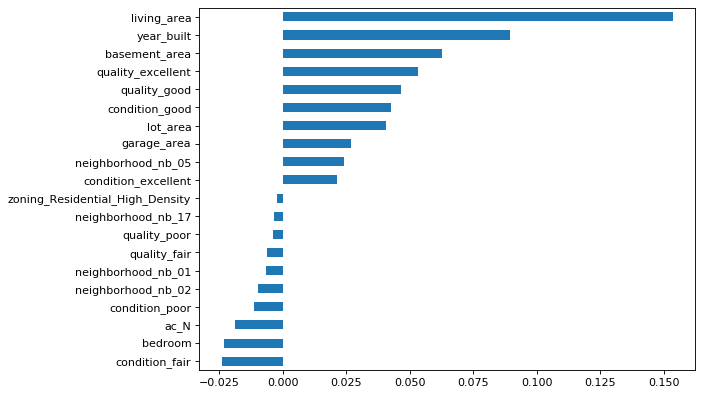

In [36]:
coef = pd.Series(lasso.coef_, index = Xt.columns)
lasso_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
lasso_coef.plot(kind = "barh")

The most important positive feature is `living_area`. This definitely make sense since in the exploratory data analysis we notice `sale_price` has linear relationship with `living_area`. Then `year_built` and `basement_area` both contribute positively. Most of the negative features come from unbalanced categorical variables.

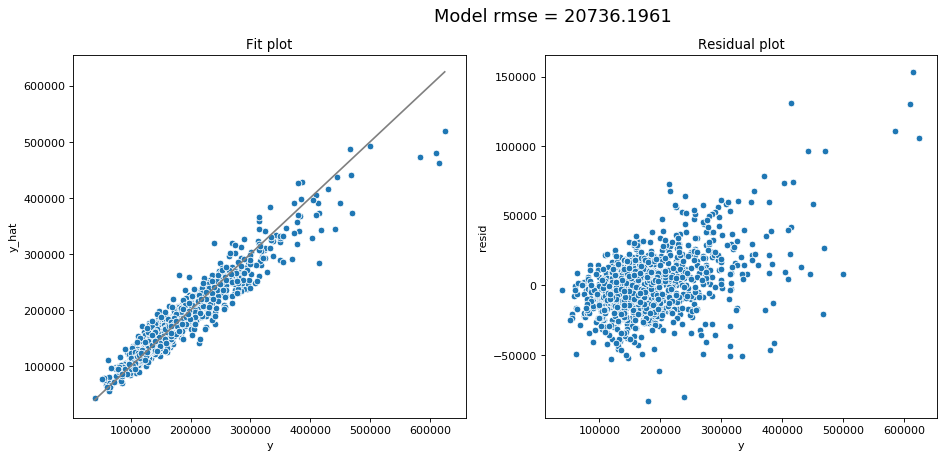

20736.196106147057

In [37]:
# Using the residual plot for training dataset
model_fit(lasso, Xt_scaled, yt, plot = True)

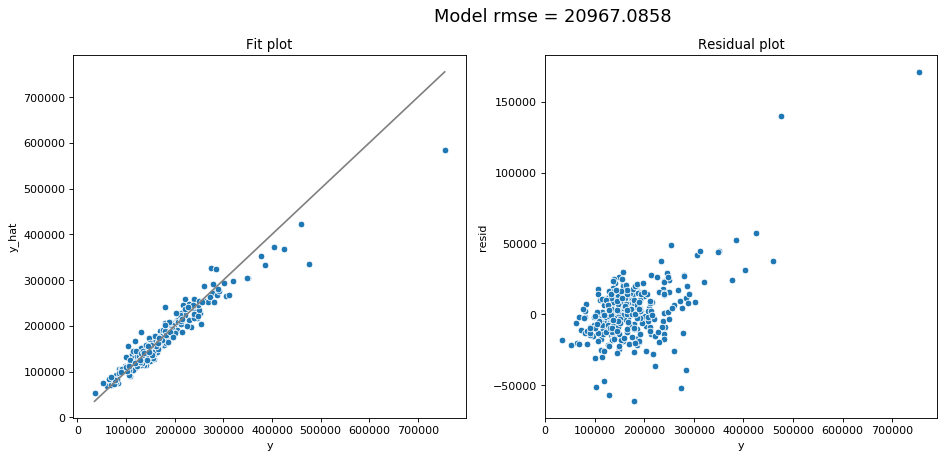

20967.085838613977

In [38]:
# Using the residual plot for validation dataset
model_fit(lasso, Xv_scaled, yv, plot = True)

### Ridge Regression

In [39]:
from sklearn.linear_model import Ridge
alphas = np.linspace(0.01, 15, num=100)
ridge_gs = GridSearchCV(
    Ridge(),
    param_grid={'alpha': alphas},
    cv=KFold(5, True, random_state=1234),
    scoring='neg_mean_squared_error'
).fit(Xt_scaled, yt)

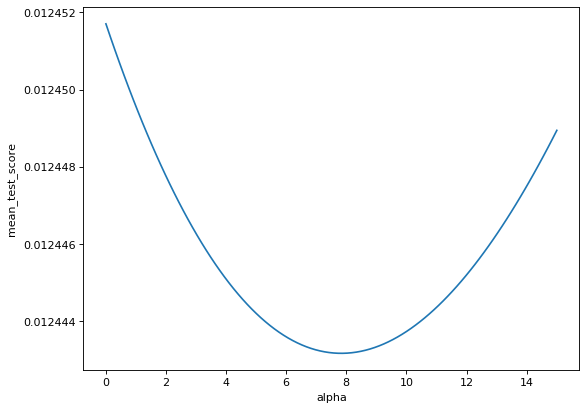

In [40]:
cv_res = pd.DataFrame(
 data = ridge_gs.cv_results_
).filter(
 # Extract the split#_test_score, mean_test_score, and std_test_score columns
 regex = '(split[0-9]+|mean)_test_score'
).assign(
 # Add the alphas as a column
 alpha = alphas
)
cv_res.update(
 # Convert negative rmses to positive
 -1 * cv_res.filter(regex = '_test_score')
)
sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
plt.show()

This plot clearly shows that the value 7.8 is obtained as the minimum of this curve. However, this plot gives us
an overly confident view of this choice of this particular value of $\alpha$.

In [41]:
print( "best alpha:", ridge_gs.best_params_['alpha'])
print( "best rmse :", ridge_gs.best_score_ * -1)
print( "validation rmse:", model_fit(ridge_gs.best_estimator_, Xv_scaled, yv))

best alpha: 7.883535353535353
best rmse : 0.01244317356507396
validation rmse: 20349.70600622422


In [42]:
ridge_cv_res = pd.DataFrame().assign(
    alpha = alphas,
    rmse = -1 * ridge_gs.cv_results_['mean_test_score'],
    rmse_se = ridge_gs.cv_results_['std_test_score'] / np.sqrt(ridge_gs.n_splits_),
)

i = ridge_cv_res.rmse.idxmin()
min_rmse = ridge_cv_res.rmse[i]
min_rmse_se = ridge_cv_res.rmse_se[i]
sub = ridge_cv_res.rmse <= min_rmse + min_rmse_se
alpha_1se = ridge_cv_res.alpha[ sub ].max()

ridge = Ridge(alpha=alpha_1se).fit(Xt_scaled, yt)
get_coefs(ridge)

array([ 1.19993610e+01, -3.48607071e-03,  8.17769786e-02,  4.42981674e-02,
        6.29686871e-02,  1.43956073e-01,  4.91193626e-03,  1.44308726e-02,
       -2.58579485e-02,  1.34507114e-02,  2.87896985e-02, -9.62126424e-03,
        9.62126424e-03, -7.11737912e-03,  4.80815575e-03, -3.44095652e-03,
       -1.33265571e-02, -1.58463497e-02,  1.38903423e-02, -5.79941659e-03,
        2.48712105e-02, -5.42706364e-03, -6.77944120e-03,  2.04435146e-03,
       -6.79275427e-03,  1.16446675e-02, -3.40609647e-04,  9.69633927e-03,
       -1.25972237e-02,  3.61773567e-03,  7.82341141e-03,  9.04369417e-03,
       -9.85844770e-03,  1.62017125e-03,  2.06127286e-02, -1.31611039e-03,
        5.81523205e-03,  3.92536424e-04,  4.94046384e-03, -5.59483315e-03,
       -2.73935648e-02,  4.23569005e-02, -1.60122554e-02,  1.79808160e-02,
       -1.19812801e-02, -2.05710174e-02,  1.96159359e-02, -3.22536450e-02,
        2.76473935e-02, -1.58024698e-02])

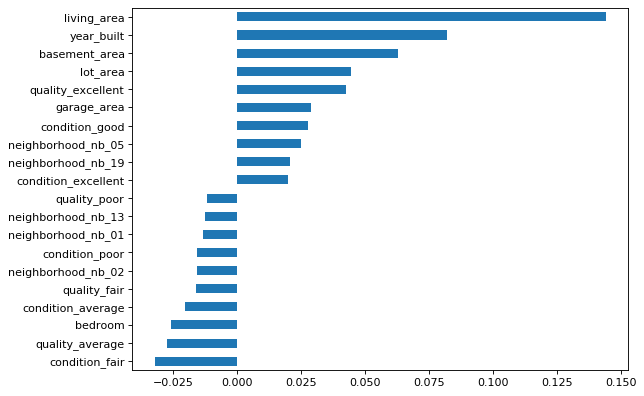

In [43]:
coef = pd.Series(ridge.coef_, index = Xt.columns)
ridge_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
ridge_coef.plot(kind = "barh")

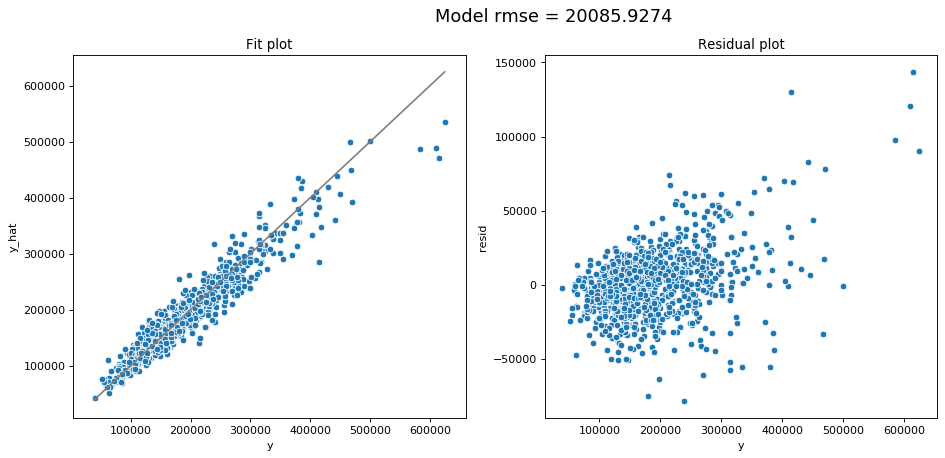

20085.92740283773

In [44]:
# Using the residual plot for training dataset
model_fit(ridge, Xt_scaled, yt, plot = True)

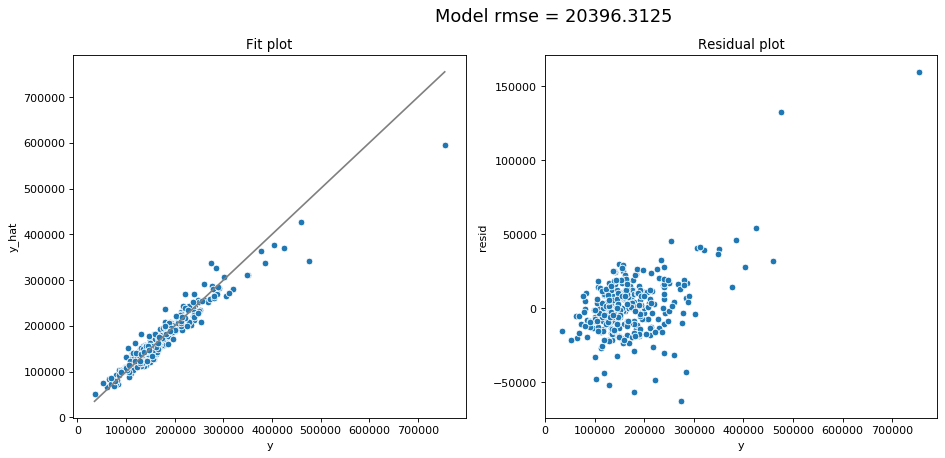

20396.31246839266

In [45]:
# Using the residual plot for validation dataset
model_fit(ridge, Xv_scaled, yv, plot = True)

| Method | Traning dataset RMSE | Validation dataset RMSE |
| ------ | ------ | ------ |
| Lasso | 20736.2| 20967.1|
| Ridge | 20085.9 | 20396.3 |

In all variables case, the RMSE of validation dataset is smaller thn training dataset. Therefore, I will choose to use ridge regression model to fit this dataset.

### Variables Selection

Since the variable of `garage_cars` and `garage_area` have high correlation and the coefficient of `garage_area` is high. And the variable of `living_area` has high correaltion with `full_bath` and `bedroom`. In order to prevent multicollinearity, we will omit the variable of `garage_cars`, `full_bath` and `bedroom`. The coefficient of `ac` and `zoning`  also small. That means the influence of those variables may not strong. We also try to omit those variable to see the impact.

In [46]:
drop_variables = ['garage_cars', 'full_bath', 'bedroom']
Xt_select = Xt.drop(drop_variables, axis=1)
Xt_select = Xt_select.drop(list(Xt_select.filter(regex='ac|zoning')), axis=1)
Xv_select = Xv.drop(drop_variables, axis=1)
Xv_select = Xv_select.drop(list(Xv_select.filter(regex='ac|zoning')), axis=1)
Xt_select.head()

,year_sold,year_built,lot_area,basement_area,living_area,half_bath,garage_area,neighborhood_nb_01,neighborhood_nb_02,neighborhood_nb_03,...,quality_average,quality_excellent,quality_fair,quality_good,quality_poor,condition_average,condition_excellent,condition_fair,condition_good,condition_poor
215,2009,7.589336,9.719264,1602,7.379008,0,529,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1179,2007,7.589336,9.181941,995,6.916715,0,576,0,0,0,...,1,0,0,0,0,0,0,0,1,0
55,2010,7.583756,9.200290,1209,7.097549,0,504,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1339,2006,7.598399,10.484585,1930,8.196161,1,807,0,0,0,...,0,1,0,0,0,1,0,0,0,0
578,2008,7.589842,9.828710,2048,7.632401,0,550,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [47]:
S = StandardScaler().fit(Xt_select)
Xt_select_scaled = S.transform(Xt_select)
Xv_select_scaled = S.transform(Xv_select)

alphas = np.linspace(0.01, 15, num=100)
ridge_select_gs = GridSearchCV(
    Ridge(),
    param_grid={'alpha': alphas},
    cv=KFold(5, True, random_state=1234),
    scoring='neg_mean_squared_error'
).fit(Xt_select_scaled, yt)

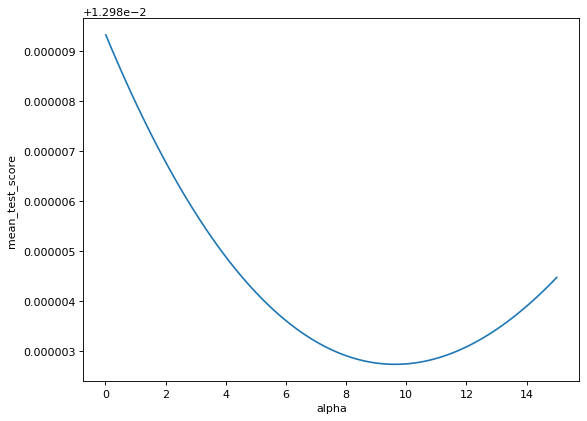

In [48]:
cv_select_res = pd.DataFrame(
    data = ridge_select_gs.cv_results_
).filter(
 # Extract the split#_test_score, mean_test_score, and std_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
 # Add the alphas as a column
    alpha = alphas
)

cv_select_res.update(
    # Convert negative rmses to positive
    -1 * cv_select_res.filter(regex = '_test_score')
)
sns.lineplot(x='alpha', y='mean_test_score', data=cv_select_res)
plt.show()

This plot clearly shows that the value between 6 and 8 is obtained as the minimum of this curve. However, this plot gives us an overly confident view of this choice of this particular value of $\alpha$.

In [49]:
print( "best alpha:", ridge_select_gs.best_params_['alpha'])
print( "best rmse :", ridge_select_gs.best_score_ * -1)
print( "validation rmse:", model_fit(ridge_select_gs.best_estimator_, Xv_select_scaled, yv))

best alpha: 9.70050505050505
best rmse : 0.012982730155641753
validation rmse: 20919.725109525854


In [50]:
ridge_select_cv_res = pd.DataFrame().assign(
    alpha = alphas,
    rmse = -1 * ridge_select_gs.cv_results_['mean_test_score'],
    rmse_se = ridge_select_gs.cv_results_['std_test_score'] / np.sqrt(ridge_select_gs.n_splits_),
)

i = ridge_select_cv_res.rmse.idxmin()
min_rmse = ridge_select_cv_res.rmse[i]
min_rmse_se = ridge_select_cv_res.rmse_se[i]
sub = ridge_select_cv_res.rmse <= min_rmse + min_rmse_se
alpha_1se = ridge_select_cv_res.alpha[ sub ].max()

ridge_select = Ridge(alpha=alpha_1se).fit(Xt_select_scaled, yt)

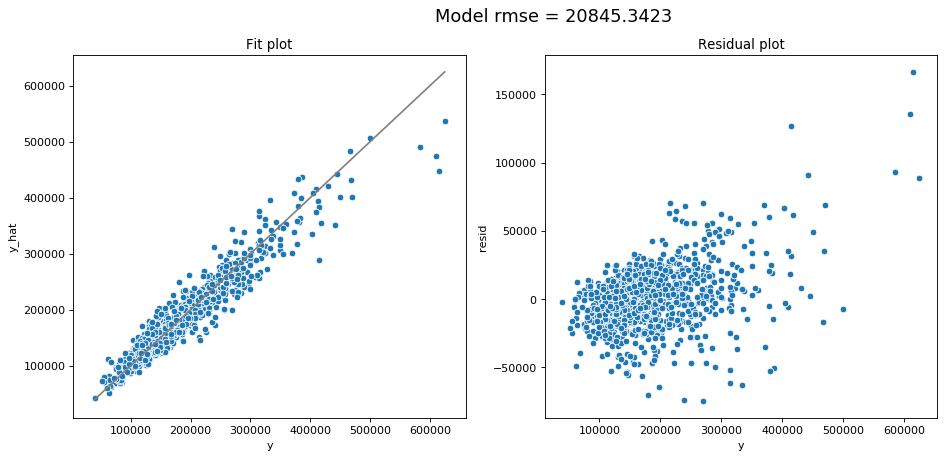

20845.342303408117

In [51]:
# Using the residual plot for training dataset
model_fit(ridge_select, Xt_select_scaled, yt, plot = True)

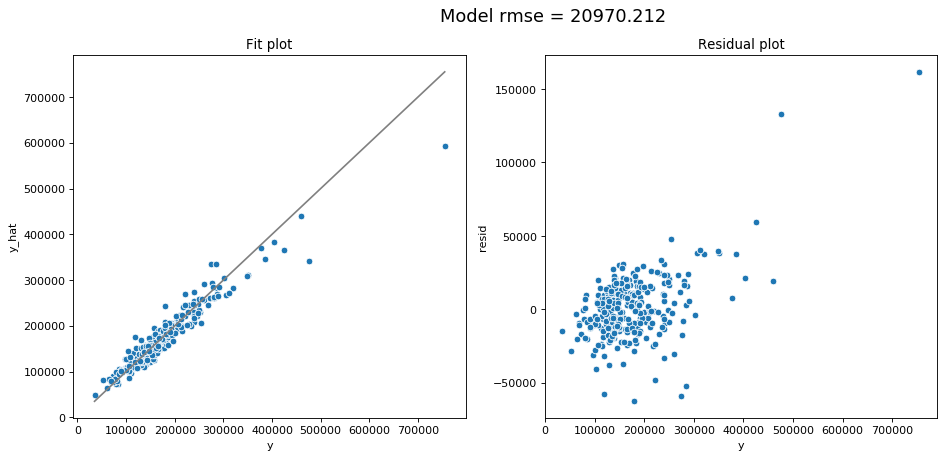

20970.212044613534

In [52]:
# Using the residual plot for testing dataset
model_fit(ridge_select, Xv_select_scaled, yv, plot = True)

According to the above, we can notice that this dataset is high dimensional input. And there are some variables are continuous variables. If we try to use linear regression, there can be a lot of variability in the least squares fit, resulting in overfitting and consequently poor prediction. In this project, we consider use ridge regression and lasso regression. Using the Ridge regression can shrink some $\beta$ tend to $0$ but still need to consider all of varibales. Using lasso regression can shrink coefficient to 0 but according to the performance of validation dataset, it shows the ridge regression is more better. Then, we base on the reslut of all variables to omit some variables which can prevent multicollinearity issue and simplify the complexity of model.

## 4. Discussion


We choose Ridge regression model to fit our dataset. Some of features are continuous and others are categorical so we transform the categorical variables into dummy variables and include the following variables into model.

***Overview the final model:***
1. We drop the variable of `garage_cars`, `full_bath`, `bedroom`, `ac` and `zoning`, so we use the rest of variables to build model. In the lasso regression, it automatically select the variables. In the end, we include `year_sold`, `year_built` `lot_area` `basement_area` `living_area` `half_bath` `garage_area`, `neighborhood`, `quality` and `condition` into model.
2. There are some variables are skewed (ex. `sale_price`, `year_built`, `lot_area` and `living_area`), so before we put into model we will use log to hanlde skewness.

In [53]:
# Final model
def final_model(X):
    """Returns the predict sale price by input X using our final model.
    Args:
        X: Input all features without sale_price
    """
    X.year_built = np.log(X.year_built)
    X.lot_area = np.log(X.lot_area)
    X.living_area = np.log(X.living_area)
    X_drop = X.drop(['garage_cars', 'full_bath', 'bedroom', 'ac', 'zoning'], axis = 1)
    X_dum = pd.get_dummies(X_drop)

    S = StandardScaler().fit(X_dum)
    X_scaled = S.transform(X_dum)
    y_hat = np.exp(ridge_select.predict(X_scaled))
    return y_hat

# The function is for countiing RMSE
def rmse(y, y_pred):
    """Returns the root mean squared error of based on provided y_true and y_pred values.
    Args:
        y_true: The true of y from the DataFrame
        y_pred: The predict y using the model 
    """
    return np.sqrt(mean_squared_error(y, y_pred))

Then we use the file `sales_test.csv` to test the performance.

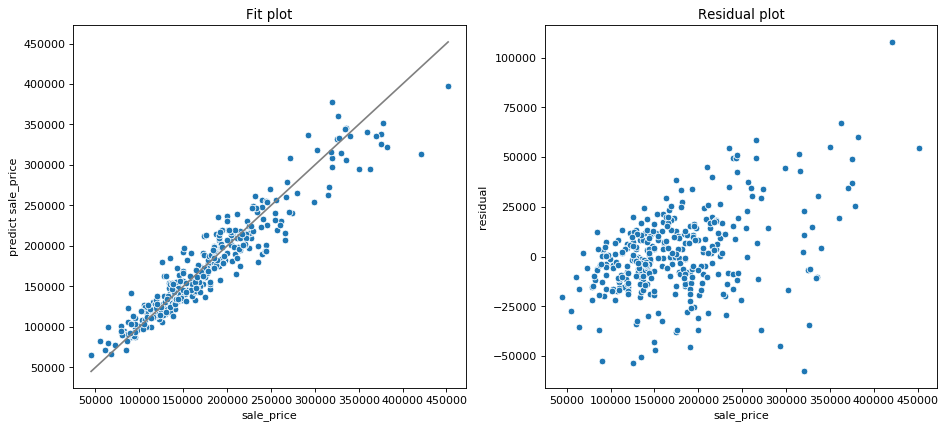

Model rmse is = 20869.630588134012


In [54]:
# Using the test file to test the predictive performance
X_test = sales_test.drop('sale_price', axis=1)
y_test = sales_test.sale_price
y_pred = final_model(X_test)
residual = y_test - y_pred

table = pd.DataFrame(
        data = {'sale_price': y_test, 'predict sale_price': y_pred, 'residual': y_test - y_pred}
    )

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x = 'sale_price', y = 'predict sale_price', data = table).set_title("Fit plot")
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], c="grey")
plt.subplot(122)
sns.scatterplot(x = 'sale_price', y = 'residual', data = table).set_title("Residual plot")
plt.subplots_adjust(left=0.0)
plt.show()

print("Model rmse is =", rmse(y_test, y_pred))

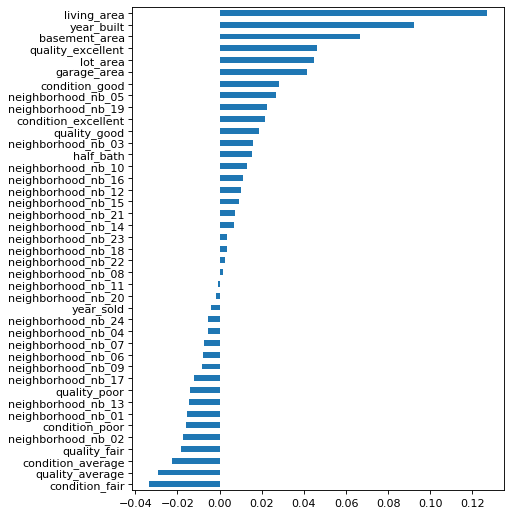

In [62]:
coef = pd.Series(ridge_select.coef_, index = Xt_select.columns)
ridge_coef = coef.sort_values()
plt.figure(figsize=(6, 8))
ridge_coef.plot(kind = "barh")

We can see that the sale price with the prediction is not bad same as residual plot. When we put the data into final model and we can get the rmse of model is $20869.6$. In terms of the coefficient in the model, we can notice that most coefficients are reasonable. This model give the positive coefficients for postive features and negative coefficients for drawbacks. For example, we all know that as living_area is large, the sale price will become larger as well and if condition or quality is not good, they will lead the sale price to decrease. But there is a point that is worth to discuss. We think quality will influence house price, but it seems the impact of `quality poor` won't be an obstacle toward house price. Probably, the sample size is too small, thus, the influence of this feature won't be stronger than others. 

## 5. Model Validation

In this model, we didnt include the variable of `garage_cars`, `full_bath`, `bedroom`, `ac` and `zoning`. So if those variables are important to the house price toward an area then it will influence the predictive performance. And, this model didnt consider the interaction term therefore if some interaction terms are important in certain places, they also will impact the result. Besides, this model didnt consider the influence of external factors (for example financial crisis or earthquake etc) which may also affect the performance of prediction.

In [63]:
sales_holdout = pd.read_csv("sales_holdout.csv")
X_holdout = sales_holdout.drop('sale_price', axis=1)
y_holdout = sales_holdout.sale_price

In [64]:
y_holdout_predict = final_model(X_holdout)

In [65]:
# Calculate the root mean squared error for your model
print('The root mean squared error for model is :', 
      np.sqrt(sklearn.metrics.mean_squared_error(y_holdout, y_holdout_predict)))

The root mean squared error for model is : 20869.630588134012
